# IMPORT DEPENDENCIES

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import time
import shutil
import pathlib
import itertools
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.metrics import Precision, Recall, AUC

# DATA LOADING

In [ ]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
categories = ["Normal","Osteopenia", "Osteoporosis"]

In [ ]:
TfDatasetsPath = 'TfDatasets'

In [ ]:
trainDataset = tf.data.Dataset.load(TfDatasetsPath + "/trainDataset")
validDataset = tf.data.Dataset.load(TfDatasetsPath + "/validDataset")
testDataset = tf.data.Dataset.load(TfDatasetsPath + "/testDataset")

In [ ]:
trainDataset = trainDataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validDataset = validDataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
testDataset = testDataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
trainDataset

# XCEPTION MODEL

In [20]:
metrics = [Precision(), Recall(), AUC(), 'accuracy']

2025-02-25 06:40:59.421435: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-25 06:40:59.421475: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-02-25 06:40:59.421481: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1740494459.421858 11340107 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1740494459.422111 11340107 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
def create_xception_model(input_shape, num_classes=3, learning_rate=1e-4):
    inputs = tf.keras.layers.Input(shape=input_shape, name="Input_Layer")
    base_model = tf.keras.applications.Xception(weights="imagenet", input_tensor=inputs, include_top=False, name="Xception")
    base_model.trainable = False
    x = base_model.output
    height, width, channels = x.shape[1], x.shape[2], x.shape[3]
    x = tf.keras.layers.Reshape((height * width, channels), name="Reshape_to_Sequence")(x)
    x = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=channels, name="Multi_Head_Attention")(x, x)
    x = tf.keras.layers.Reshape((height, width, channels), name="Reshape_to_Spatial")(x)
    x = tf.keras.layers.GaussianNoise(0.25, name="Gaussian_Noise")(x)
    x = tf.keras.layers.GlobalAveragePooling2D(name="Global_Avg_Pooling")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="FC_512")(x)
    x = tf.keras.layers.BatchNormalization(name="Batch_Normalization")(x)
    x = tf.keras.layers.Dropout(0.5, name="Dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax",name="Output_Layer")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="Xception_with_Attention")
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
    return model

# TRAINING

In [22]:
input_shape = (224, 224, 3)
cnn_model = create_xception_model(input_shape, num_classes=3, learning_rate=1e-4)

In [23]:
cnn_model.summary()

Model: "Xception_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ Input_Layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 156,183,083 (595.79 MB)

 Trainable params: 135,320,579 (516.21 MB)

 Non-trainable params: 20,862,504 (79.58 MB)

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

In [25]:
history = cnn_model.fit( train_gen_new,
                         validation_data=valid_gen_new,
                         epochs=250,
                         callbacks=[early_stopping],
                         verbose=1)

Epoch 1/250


2025-02-25 06:41:01.552195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


95/95 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.4943 - auc: 0.6682 - loss: 1.6965 - precision: 0.5066 - recall: 0.4543 - val_accuracy: 0.6296 - val_auc: 0.8066 - val_loss: 0.8218 - val_precision: 0.7029 - val_recall: 0.5132
Epoch 2/250
95/95 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.5797 - auc: 0.7614 - loss: 1.1186 - precision: 0.5988 - recall: 0.5558 - val_accuracy: 0.6323 - val_auc: 0.8000 - val_loss: 0.9819 - val_precision: 0.6562 - val_recall: 0.6058
Epoch 3/250
95/95 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.6560 - auc: 0.8196 - loss: 0.9582 - precision: 0.6732 - recall: 0.6240 - val_accuracy: 0.5979 - val_auc: 0.7554 - val_loss: 1.5045 - val_precision: 0.6011 - val_recall: 0.5899
Epoch 4/250
95/95 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.6589 - auc: 0.8290 - loss: 0.9427 - precision: 0.6690 - recall: 0.6295 - val_accuracy: 0.6746 - val_auc: 0.8254 - val_loss: 0.9440 - val_precision: 0.6806 - val_recall: 0.6481
Epoch 5/250
95/95 ━━━━━━━━━━━━━━━━━━━━ 173s 

# FINE-TUNING

In [26]:
for layer in cnn_model.layers[1:-9]:
    layer.trainable = True

In [27]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=7e-5), loss="categorical_crossentropy", metrics=metrics)


In [28]:
cnn_model.summary()

Model: "Xception_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ Input_Layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 156,183,083 (595.79 MB)

 Trainable params: 156,127,531 (595.58 MB)

 Non-trainable params: 55,552 (217.00 KB)

In [29]:
history = cnn_model.fit( train_gen_new,
                         validation_data=valid_gen_new,
                         epochs=250,
                         callbacks=[early_stopping],
                         verbose=1)

Epoch 1/250
95/95 ━━━━━━━━━━━━━━━━━━━━ 483s 5s/step - accuracy: 0.5569 - auc: 0.7597 - loss: 1.3790 - precision: 0.6131 - recall: 0.5490 - val_accuracy: 0.4550 - val_auc: 0.6788 - val_loss: 1.9980 - val_precision: 0.4536 - val_recall: 0.4524
Epoch 2/250
95/95 ━━━━━━━━━━━━━━━━━━━━ 433s 5s/step - accuracy: 0.6814 - auc: 0.8534 - loss: 0.8082 - precision: 0.7043 - recall: 0.6525 - val_accuracy: 0.5873 - val_auc: 0.7996 - val_loss: 1.1642 - val_precision: 0.5978 - val_recall: 0.5741
Epoch 3/250
95/95 ━━━━━━━━━━━━━━━━━━━━ 480s 5s/step - accuracy: 0.8041 - auc: 0.9314 - loss: 0.5210 - precision: 0.8228 - recall: 0.7863 - val_accuracy: 0.4974 - val_auc: 0.7140 - val_loss: 1.9925 - val_precision: 0.5000 - val_recall: 0.4894
Epoch 4/250
95/95 ━━━━━━━━━━━━━━━━━━━━ 486s 5s/step - accuracy: 0.8712 - auc: 0.9671 - loss: 0.3486 - precision: 0.8819 - recall: 0.8666 - val_accuracy: 0.5265 - val_auc: 0.7468 - val_loss: 1.8523 - val_precision: 0.5378 - val_recall: 0.5265
Epoch 5/250
95/95 ━━━━━━━━━━━━━━

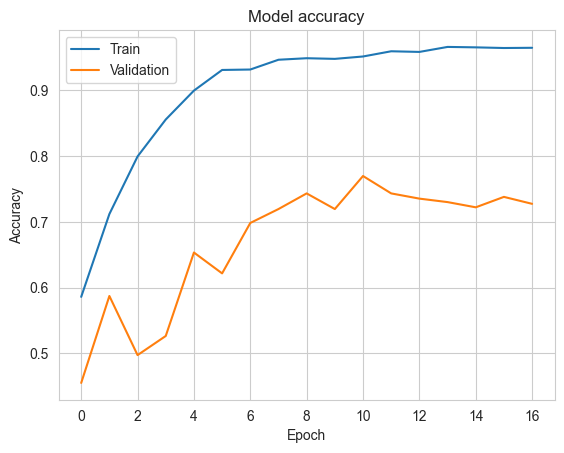

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

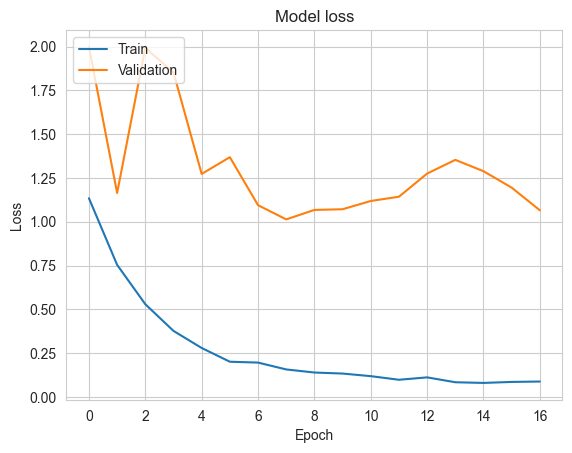

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [34]:
y_pred = cnn_model.predict(valid_gen_new)
y_true = valid_gen_new.labels
predicted_classes = np.argmax(y_pred, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 386ms/step


In [36]:
def ppo_loss(y_true, y_pred):
    epsilon = 0.2
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    selected_probs = tf.reduce_sum(y_pred * y_true_one_hot, axis=-1)
    old_selected_probs = tf.reduce_sum(tf.stop_gradient(y_pred) * y_true_one_hot, axis=-1)
    ratio = selected_probs / (old_selected_probs + 1e-10)
    clipped_ratio = tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon)
    loss = -tf.reduce_mean(tf.minimum(ratio, clipped_ratio))
    return loss

In [37]:
ppo_loss_value = ppo_loss(y_true, y_pred)
print("\nPPO Loss on Validation Data:", ppo_loss_value.numpy())


PPO Loss on Validation Data: -0.9930083


# TESTING

In [38]:
test_labels = test_gen_new.classes
predictions = cnn_model.predict(test_gen_new)
predicted_classes = np.argmax(predictions, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 366ms/step


In [39]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       126
           1       0.74      0.83      0.78       126
           2       0.79      0.75      0.77       126

    accuracy                           0.77       378
   macro avg       0.77      0.77      0.77       378
weighted avg       0.77      0.77      0.77       378



Text(95.72222222222221, 0.5, 'True Label')

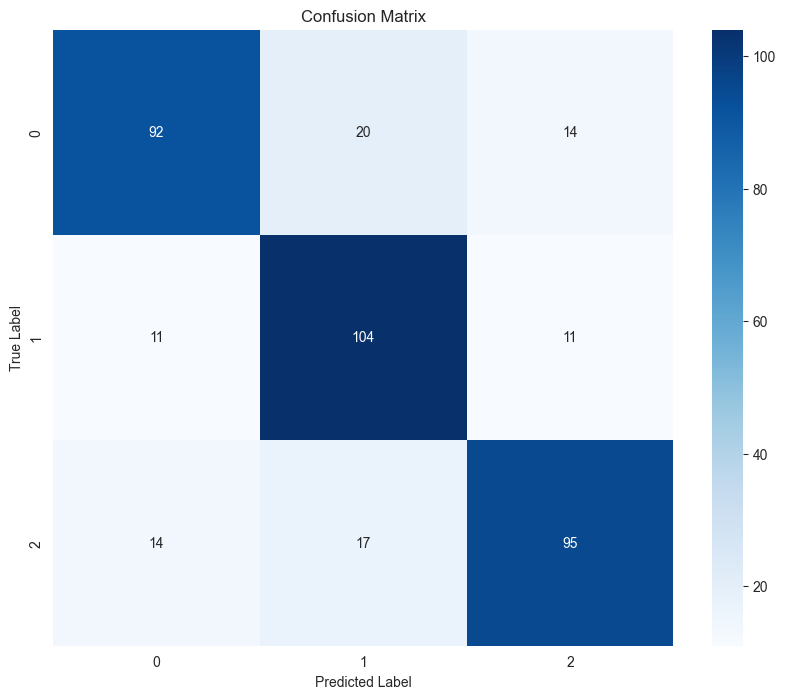

In [40]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_gen_new.class_indices.keys()),
            yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')